In another notebook (`map_exploration_of_ground_truth`), I noted that some of the merging for individual geometrical points didn't occur to be correct when merging/comparing points with boundaries that were ahead in time. They would line up and appear to work correctly with the boundaries that occured on the same day as the point, but appeared to not line up correctly with boundaries that occured a couple days in the future. 

In this notebook, I'm going to attempt to do the merging with `shapely`/`fiona`, instead of doing it with the `PostGIS` extension in `Postgres`. There were some posts online suggesting that `PostGIS` mergings can be a little finickey, so I'm seeing here if a different methodology gives the same results. If so, I think it's just a visualization thing, where the viz. alters things a little bit (it is lat/long projects, after all).  

In [1]:
import fiona 
from shapely.geometry import Point, asShape
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import datetime
from itertools import izip
from dsfuncs.geo_plotting import USMapBuilder
%matplotlib inline

First, I'll pull a bunch of functions from another notebook that I can use to visualize the `PostGIS` merging results. 

In [2]:
def read_df(year, modis=True): 
    """This function will read in a year of data, and add a month column. 
    
    Args: 
        year: str
        modis: bool
            Whether to use the modis or viirs data for plotting. 
        
    Return:
        Pandas DataFrame
    """
    if modis: 
        output_df = pd.read_csv('../../../data/csvs/day3_500m/detected_fires_MODIS_' + str(year) + '.csv', 
                                parse_dates=['date'], true_values=['t'], false_values=['f'])
    else: 
         output_df = pd.read_csv('../../../data/csvs/day3_500m/detected_fires_VIIRS_' + str(year) + '.csv', 
                                parse_dates=['date'], true_values=['t'], false_values=['f'])
    output_df['month'] = output_df.date.apply(lambda dt: dt.strftime('%B'))
    output_df.dropna(subset=['region_name'], inplace=True) # These will be obs. in Canada. 
    return output_df
    
def grab_by_location(df, state_names, county_names=None): 
    """Grab the data for a specified inputted state and county. 
    
    Args: 
        df: Pandas DataFrame
        state: set (or iterable of strings)
            State to grab for plotting.
        county: set (or iterable of strings) (optional)
            County names to grab for plotting. If None, simply grab the 
            entire state to plot. 
            
    Return: 
        Pandas DataFrame
    """
    if county_names: 
        output_df = df.query('state_name in @state_names and county_name in @county_names')
    else: 
        output_df = df.query('state_name in @state_names')
    return output_df

def grab_by_date(df, months=None, dt=None): 
    """Grab the data for a set of specified months.
    
    Args: 
        df: Pandas DataFrame
        months: set (or iterable of strings)
    
    Return: 
        Pandas DataFrame
    """
    if months is not None: 
        output_df = df.query("month in @months")
    else: 
        split_dt = dt.split('-')
        year, month, dt = int(split_dt[0]), int(split_dt[1]), int(split_dt[2])
        match_dt = datetime.datetime(year, month, dt, 0, 0, 0)
        output_df = df.query('date == @match_dt')
    return output_df

def format_df(df): 
    """Format the data to plot it on maps. 
    
    This function will grab the latitude and longitude 
    columns of the DataFrame, and return those, along 
    with a third column that will be newly generated. This 
    new column will hold what color we want to use to plot 
    the lat/long coordinate - I'll use red for fire and 
    green for non-fire. 
    
    Args: 
        df: Pandas DataFrame
    
    Return: 
        numpy.ndarray
    """
    
    keep_cols = ['long', 'lat', 'fire_bool']
    intermediate_df = df[keep_cols]
    output_df = parse_fire_bool(intermediate_df)
    output_array = output_df.values
    return output_array

def parse_fire_bool(df): 
    """Parse the fire boolean to a color for plotting. 
    
    Args: 
        df: Pandas DataFrame
        
    Return: 
        Pandas DataFrame
    """
    
    # Plot actual fires red and non-fires green. 
    output_df = df.drop('fire_bool', axis=1)
    output_df['plotting_mark'] = df['fire_bool'].apply(lambda f_bool: 'ro' if f_bool == True else 'go')
    return output_df

def read_n_parse(year, state_names, county_names=None, months=None, plotting=False, dt=None): 
    """Read and parse the data for plotting.
    
    Args: 
        year: str
        state_names: set (or other iterable) of state names
            State names to grab for plotting. 
        county_names: set (or other iterable) of county names (optional)
            County names to grab for plotting. 
        months: months (or other iterable) of months (optional)
            Month names to grab for plotting. 
        plotting: bool 
            Whether or not to format the data for plotting. 
            
    Return: 
        Pandas DataFrame
    """
    
    fires_df = read_df(year)
    if state_names: 
        fires_df = grab_by_location(fires_df, state_names, county_names)
    
    if months or dt: 
        fires_df = grab_by_date(fires_df, months, dt)
    
    if plotting: 
        fires_df = format_df(fires_df)
    return fires_df

def plot_states(year, state_names, months=None, plotting=True): 
    """Plot a state map and the given fires data points for that state. 
    
    Args: 
        year: str
        state_names: set (or other iterable) of state names
            State names to grab for plotting. 
        months: set (or other iterable) of month names 
            Month names to grab for plotting. 
        plotting: bool 
            Whether or not to format the data for plotting. 
    
    Return: Plotted Basemap
    """
    ax = plt.subplot(1, 2, 1)
    state_map = USMapBuilder('data/state_shapefiles_2014/cb_2014_us_state_500k2.shp', geo_level='State', 
                        state_names=state_names, ax=ax, border_padding=1)
    fires_data = read_n_parse(year, state_names, months=months, plotting=plotting)
    fires_data_trues = fires_data[fires_data[:,2] == 'ro']
    fires_data_falses = fires_data[fires_data[:,2] == 'go']
    print fires_data_trues.shape, fires_data_falses.shape
    state_map.plot_points(fires_data_trues)
    ax = plt.subplot(1, 2, 2)
    state_map = USMapBuilder('data/state_shapefiles_2014/cb_2014_us_state_500k2.shp', geo_level='State',  
                        state_names=state_names, ax=ax, border_padding=1)
    state_map.plot_points(fires_data_falses)
    plt.show()
    
def grab_fire_perimeters(dt, st_name, st_abbrev, st_fips, county=False): 
    """Grab the fire perimter boundaries for a given state and year.
    
    Args: 
        dt: str
        st_name: str
            State name of boundaries to grab. 
        st_abbrev: str
            State abbreviation used for bash script. 
        st_fips: str
            State fips used for bash script. 
            
    Return: Shapefile features. 
    """
            
    # Run bash script to pull the right boundaries from Postgres. 
    subprocess.call("./grab_perim_boundary.sh {} {} {}".format(st_abbrev, st_fips, dt), shell=True)
    
    filepath = 'data/{}/{}_{}_2D'.format(st_abbrev, st_abbrev, dt)
    return filepath

def plot_st_fires_boundaries(dt, st_name, st_abbrev, st_fips): 
    """Plot the fire boundaries for a year and given state.
    
    Args
    ----
        dt: str
            Contains date of boundaries to grab. 
        state_name: str
            Holds state to plot. 
        st_abbrev: str
            Holds the states two-letter abbreviation. 
        st_fips: str
            Holds the state's fips number. 
        
    Return: Plotted Basemap
    """
    
    boundaries_filepath = grab_fire_perimeters(dt, st_name, st_abbrev, st_fips)
    st_map = USMapBuilder('data/state_shapefiles_2014/cb_2014_us_state_500k2.shp', geo_level='State', 
                          state_names=[st_name], border_padding=1)
    st_map.plot_boundary(boundaries_filepath)
    plt.show()
    
def plot_counties_fires_boundaries(year, state_name, st_abbrev, st_fips, county_name, 
                                   months=None, plotting=True, markersize=4): 
    """Plot a county map in a given state, including any fire perimeter boundaries and potentially
    detected fires in those counties. 
    
    Args: 
        year: str
        state_name: str
            State name to grab for plotting. 
        st_abbrev: str
            Holds the states two-letter abbrevation
        st_fips: str
            Holds the state's fips number. 
        county_name: str or iterable of strings 
            County names to grab for plotting. 
        months: set (or other iterable) of strings (optional)
            Month names to grab for plotting
        plotting: bool
            Whether or not to format the data for plotting. 
    """
    
    county_name = county_name if isinstance(county_name, list) else [county_name]
    county_map = USMapBuilder('data/county_shapefiles_2014/cb_2014.shp', geo_level='County', 
                state_names=[state_name], county_names=county_name, figsize=(40, 20), border_padding=0.1)
    boundaries_filepath = grab_fire_perimeters(year, state_name, st_abbrev, st_fips)
    county_map.plot_boundary(boundaries_filepath)
    if plotting: 
        fires_data = read_n_parse(year, state_name, months=months, plotting=plotting)
        county_map.plot_points(fires_data, markersize)
    plt.show()

def plot_county_dt(st_name, st_abbrev, st_fips, county_name, fires_dt=None, perims_dt=None, 
                  markersize=2): 
    """Plot all obs., along with the fire-perimeter boundaries, for a given county and date. 
    
    Read in the data for the inputted year and parse it to the given state/county and date. 
    Read in the fire perimeter boundaries for the given state/county and date, and parse 
    those. Plot it all. 
    
    Args: 
        st_name: str
            State name to grab for plotting. 
        st_abbrev: str
            State abbrevation used for the bash script. 
        st_fips: str
            State fips used for the base script. 
        county_name: str
            County name to grab for plotting. 
        dt: str
            Date to grab for plotting. 
        markersize (optional): int
            Used to control the size of marker to use for plotting fire points. 
    """
    
    year = fires_dt.split('-')[0]
    perims_dt = fires_dt if not perims_dt else perims_dt
    county_names = [county_name] if not isinstance(county_name, list) else county_name
    fires_data = read_n_parse(year, state_names=st_name, county_names=county_name, dt=fires_dt, plotting=True)
    print fires_data.shape
    print county_name, st_name
    county_map = USMapBuilder('data/county_shapefiles_2014/cb_2014.shp', geo_level='County', 
                state_names=[st_name], county_names=county_names, figsize=(40, 20), border_padding=0.1)
    fire_boundaries = grab_fire_perimeters(perims_dt, st_name, st_abbrev, st_fips)
    try: 
        county_map.plot_boundary(fire_boundaries)
    except Exception as e:
        print e
    print len(fires_data)
    county_map.plot_points(fires_data, markersize=6)
    plt.show()

Now, I'll build some new functions to work on conducting the merging using `fiona`/`shapely`. 

In [3]:
def plot_shapely(state_name, st_abbrev, st_fips, cnty_name, fires_dt, 
                perims_dt): 
    """Plot observations as fires/non-fires from shapely calculations. 
    
    Args: 
    ----
        state_name: str
        st_abbrev: str
        cnty_name: list of strs or str
        fires_dt: str
            Date to grab fire observations from. 
        perims_dt: str
            Date to grab fire perimeters from. 
    """
    cnty_name = [cnty_name] if not isinstance(cnty_name, list) else cnty_name

    date_parts = fires_dt.split('-')
    fires_data = read_n_parse(date_parts[0], state_names=state_name, county_names=cnty_name, dt=fires_dt, plotting=False)
    lat_longs = fires_data[['lat', 'long']]
    lat_longs.reset_index(drop=True, inplace=True)
    lat_longs['fire_bool'] = False
    
    points = []
    for lat, lng in izip(lat_longs['lat'], lat_longs['long']): 
        points.append(Point(lng, lat))
    
    filepath = grab_fire_perimeters(perims_dt, state_name, st_abbrev, st_fips)
    perimeters = fiona_collection = fiona.open(filepath + '.shp')
    for idx1, perim in enumerate(perimeters): 
        lat_longs[idx1] = False
        shape = asShape(perim['geometry'])
        for idx2, point in enumerate(points):
            lat_longs.ix[idx2, idx1] = shape.distance(point) < 0.05
        lat_longs['fire_bool'] = (lat_longs['fire_bool'] | 
                                 lat_longs[idx1])
    county_map = USMapBuilder('data/county_shapefiles_2014/cb_2014.shp', geo_level='County', 
                state_names=[state_name], county_names=cnty_name, figsize=(40, 20), border_padding=0.1)
    county_map.plot_boundary(filepath)
    fires_df = format_df(lat_longs)
    county_map.plot_points(fires_df, markersize=6)
    
    plt.show()

/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

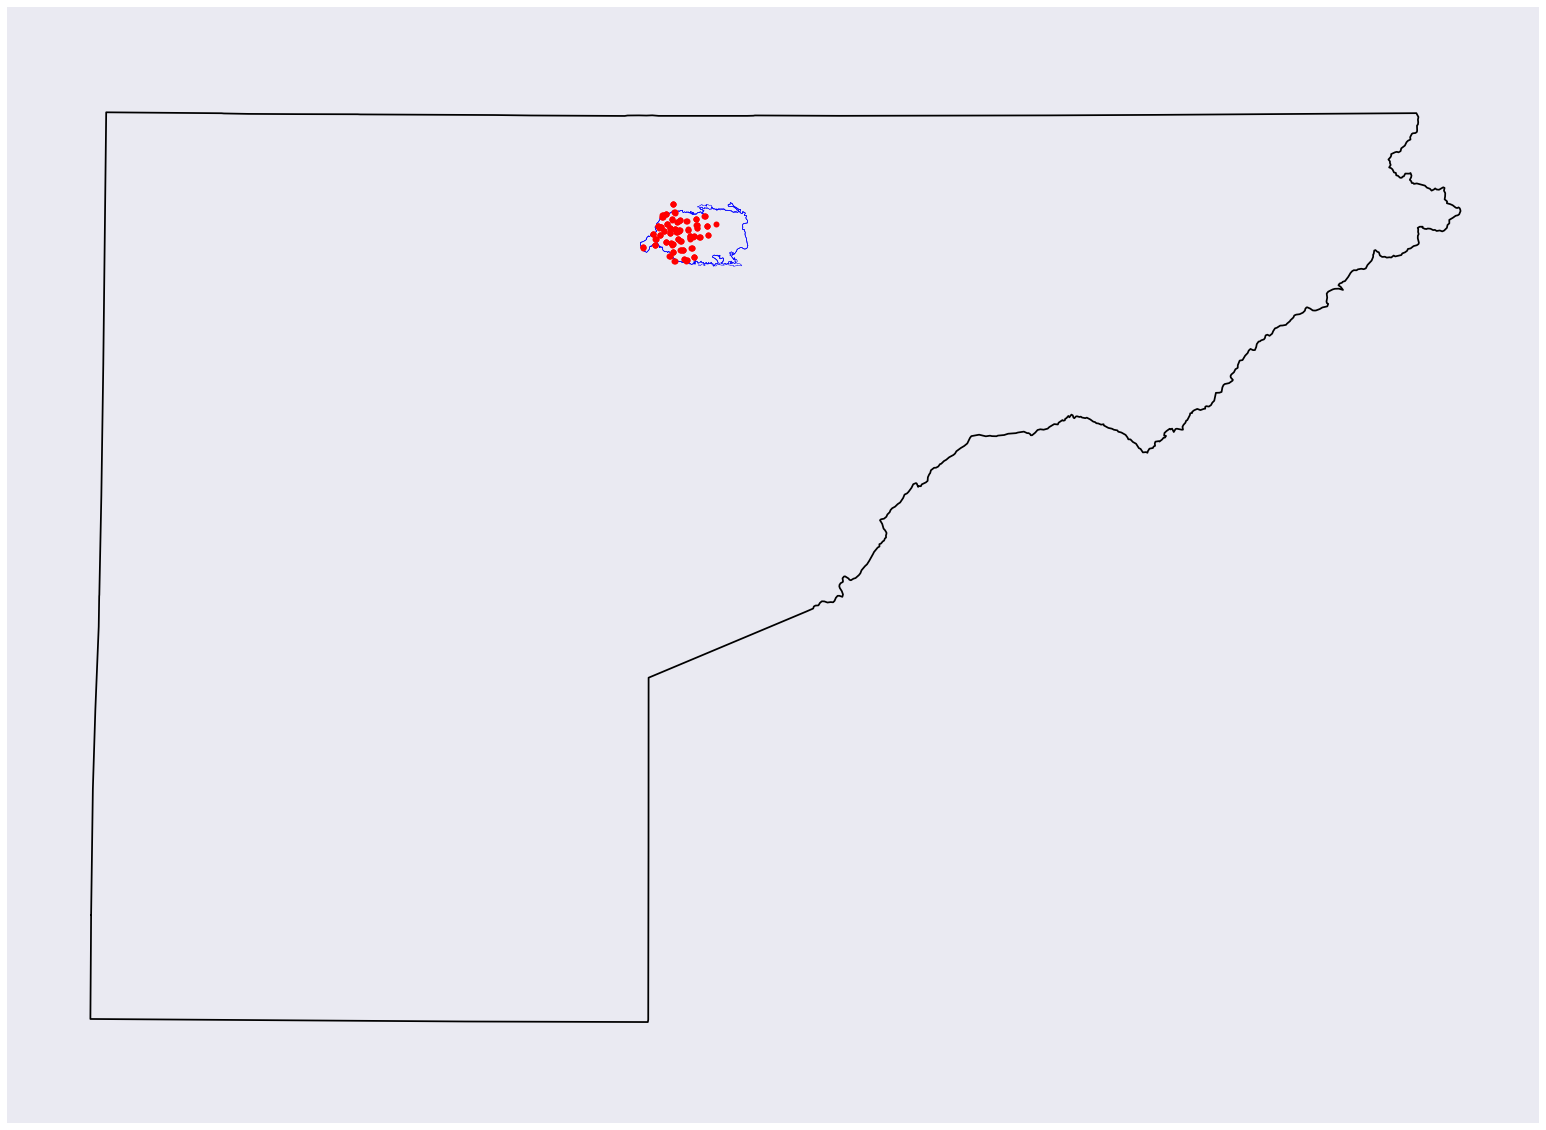

In [4]:
plot_shapely('Colorado', 'co', '08', 'Mesa', fires_dt='2012-06-28', 
                    perims_dt='2012-06-29')

(143, 3)
Mesa Colorado
143


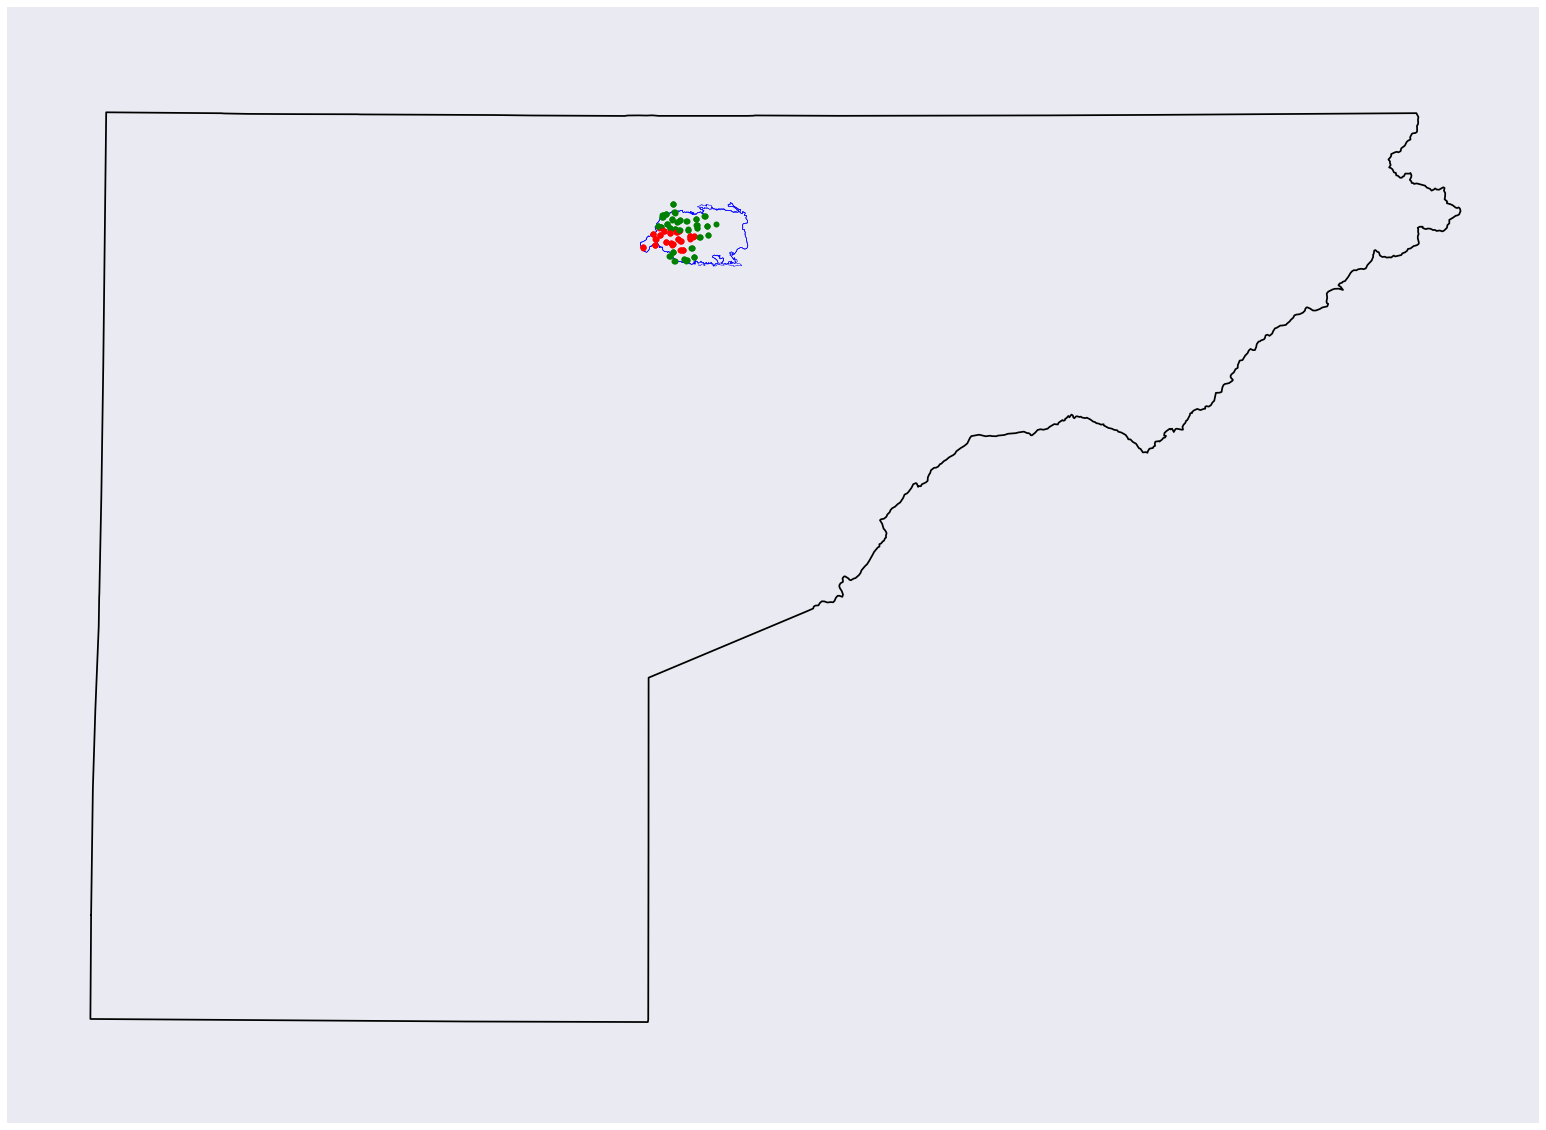

In [5]:
plot_county_dt(st_name='Colorado', st_abbrev='co', st_fips='08', 
               county_name='Mesa', fires_dt='2012-06-28', 
               perims_dt='2012-06-29')

/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

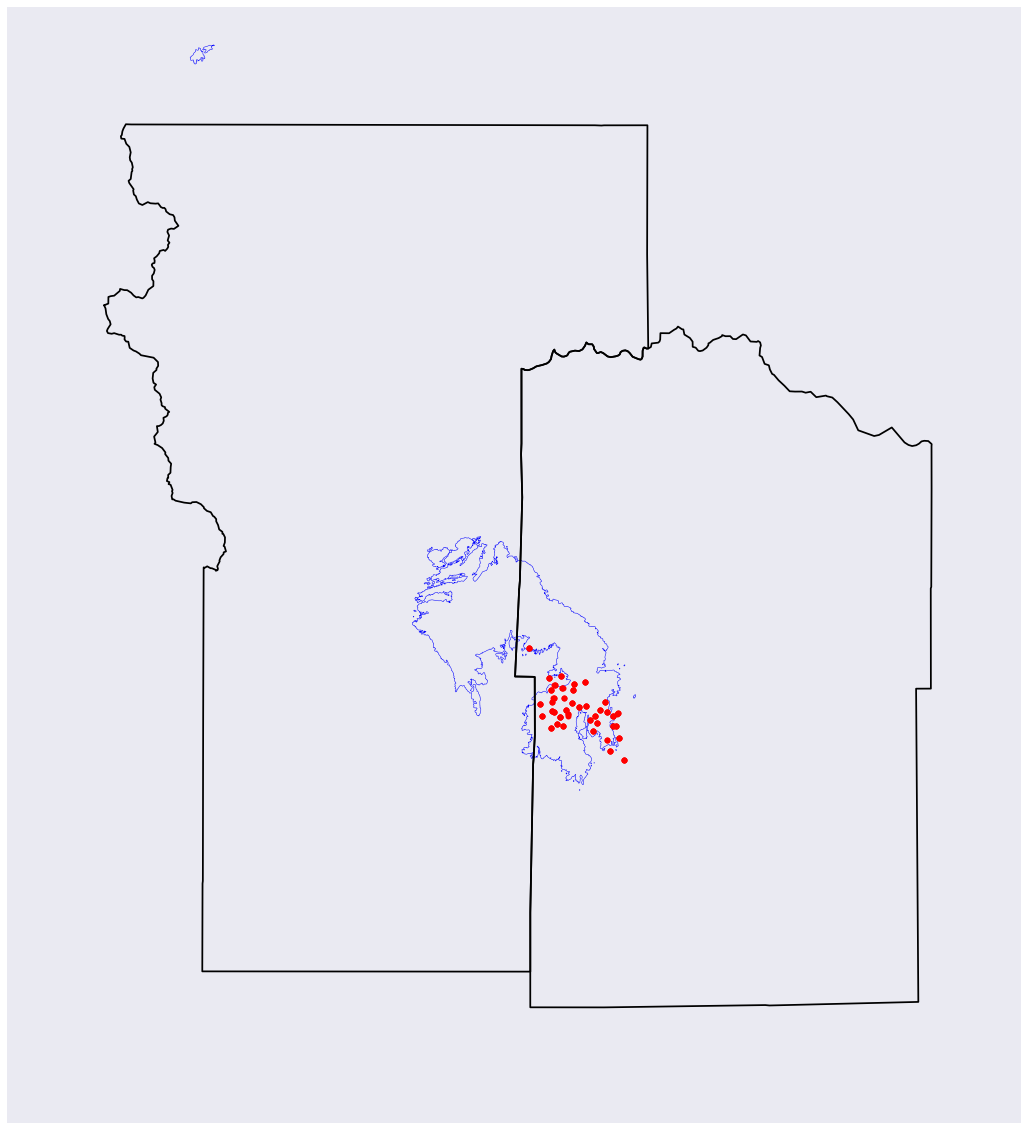

In [6]:
plot_shapely('Colorado', 'co', '08', ['Hinsdale', 'Mineral'], fires_dt='2013-07-03', 
                    perims_dt='2013-07-04')

(118, 3)
['Hinsdale', 'Mineral'] Colorado
118


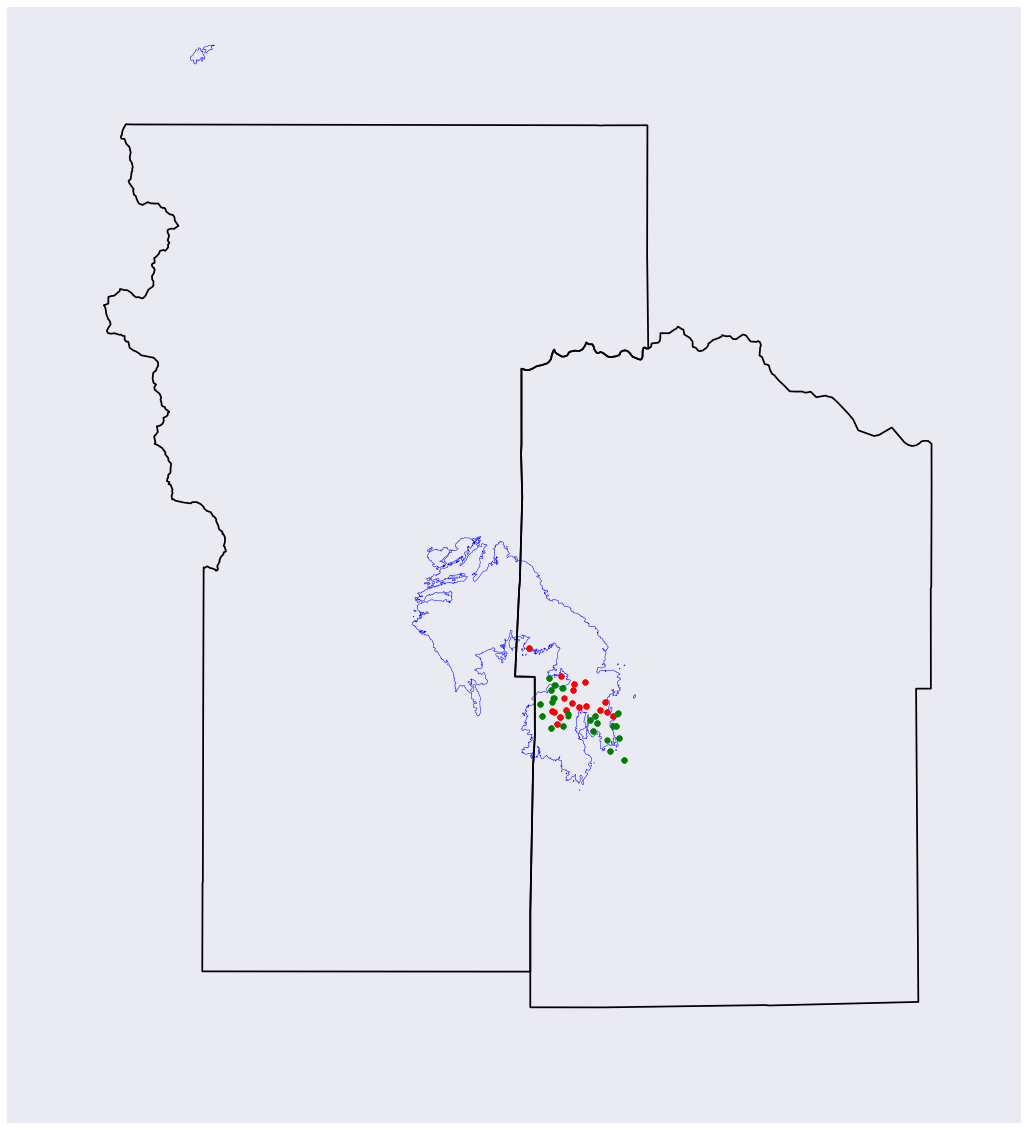

In [7]:
plot_county_dt(st_name='Colorado', st_abbrev='co', st_fips='08', 
               county_name=['Hinsdale', 'Mineral'], fires_dt='2013-07-03', 
               perims_dt='2013-07-04')

/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

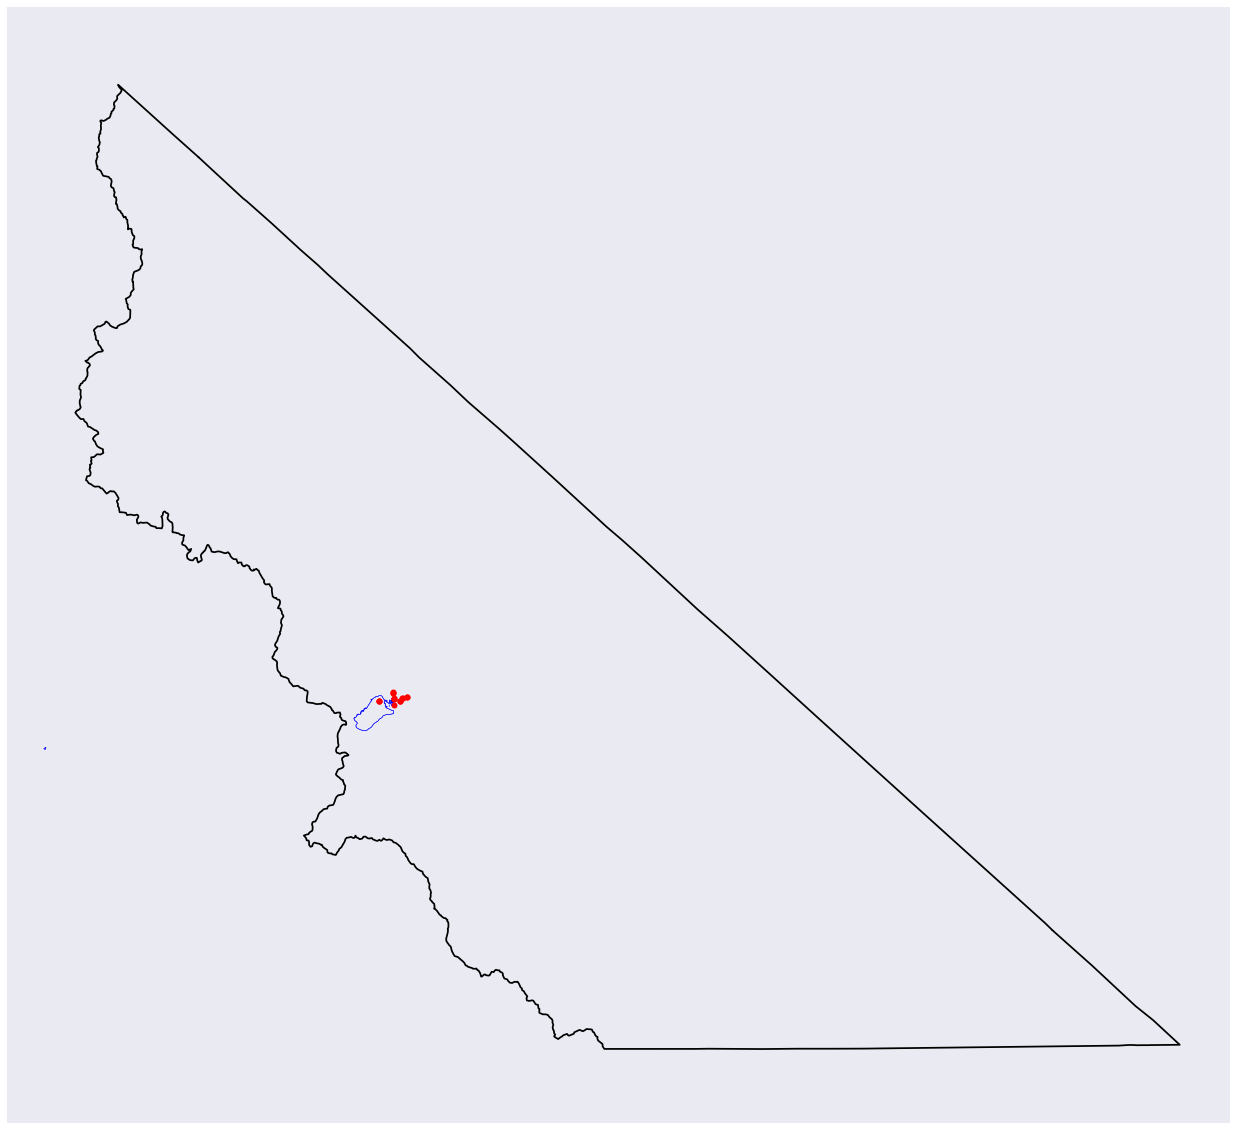

In [8]:
plot_shapely('California', 'ca', '06', 'Mono', fires_dt='2015-08-17', 
                    perims_dt='2015-08-18')

(17, 3)
Mono California
17


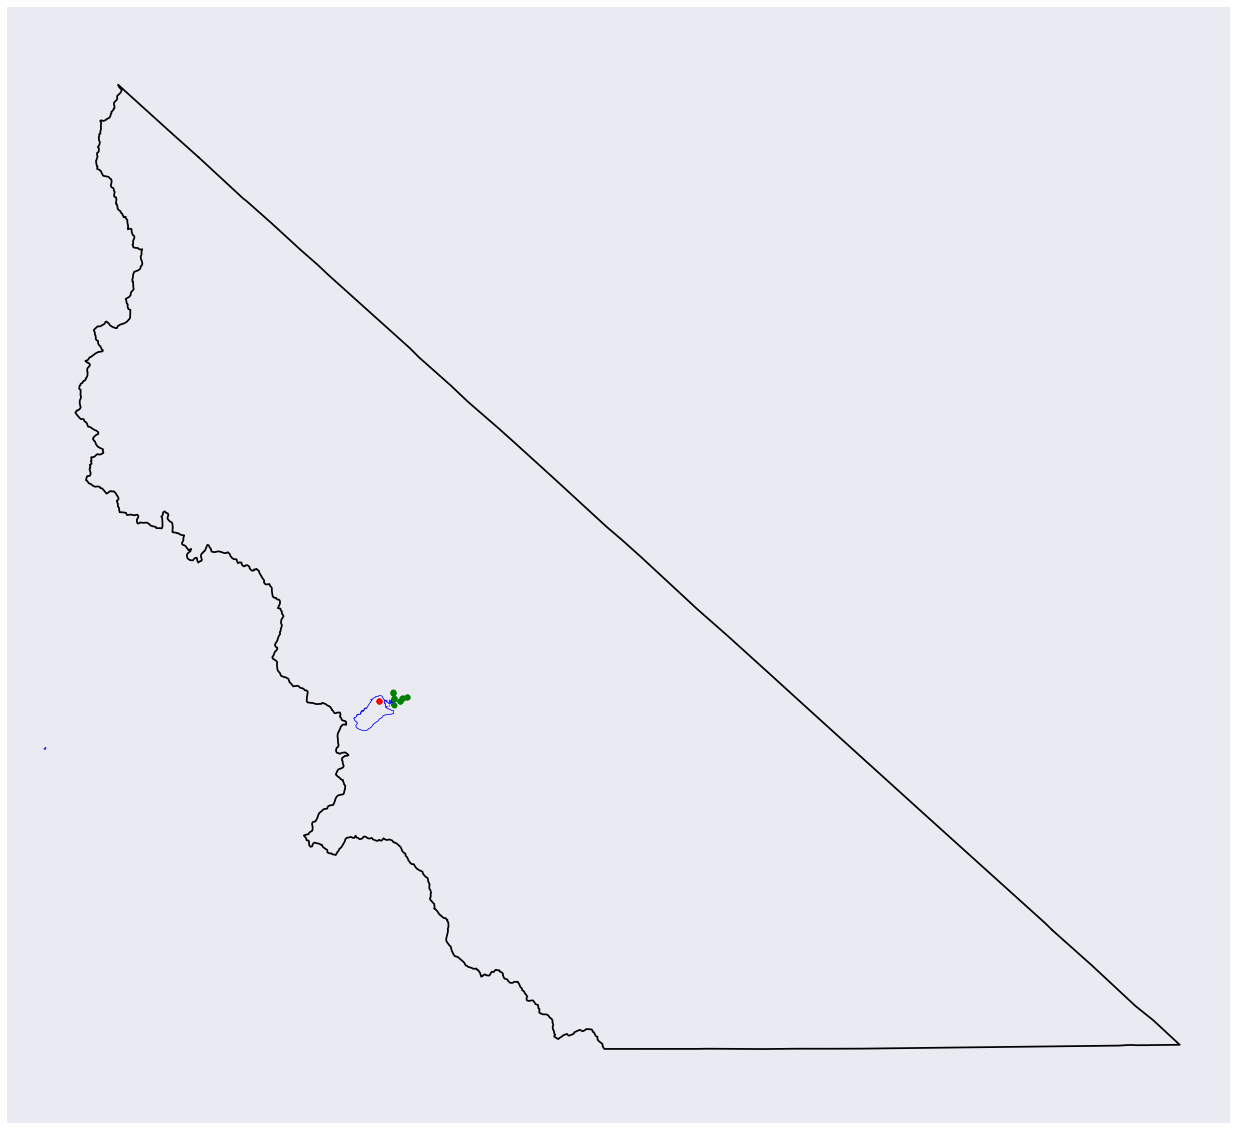

In [9]:
plot_county_dt(st_name='California', st_abbrev='ca', st_fips='06', 
               county_name='Mono', fires_dt='2015-08-17', 
               perims_dt='2015-08-18')

/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

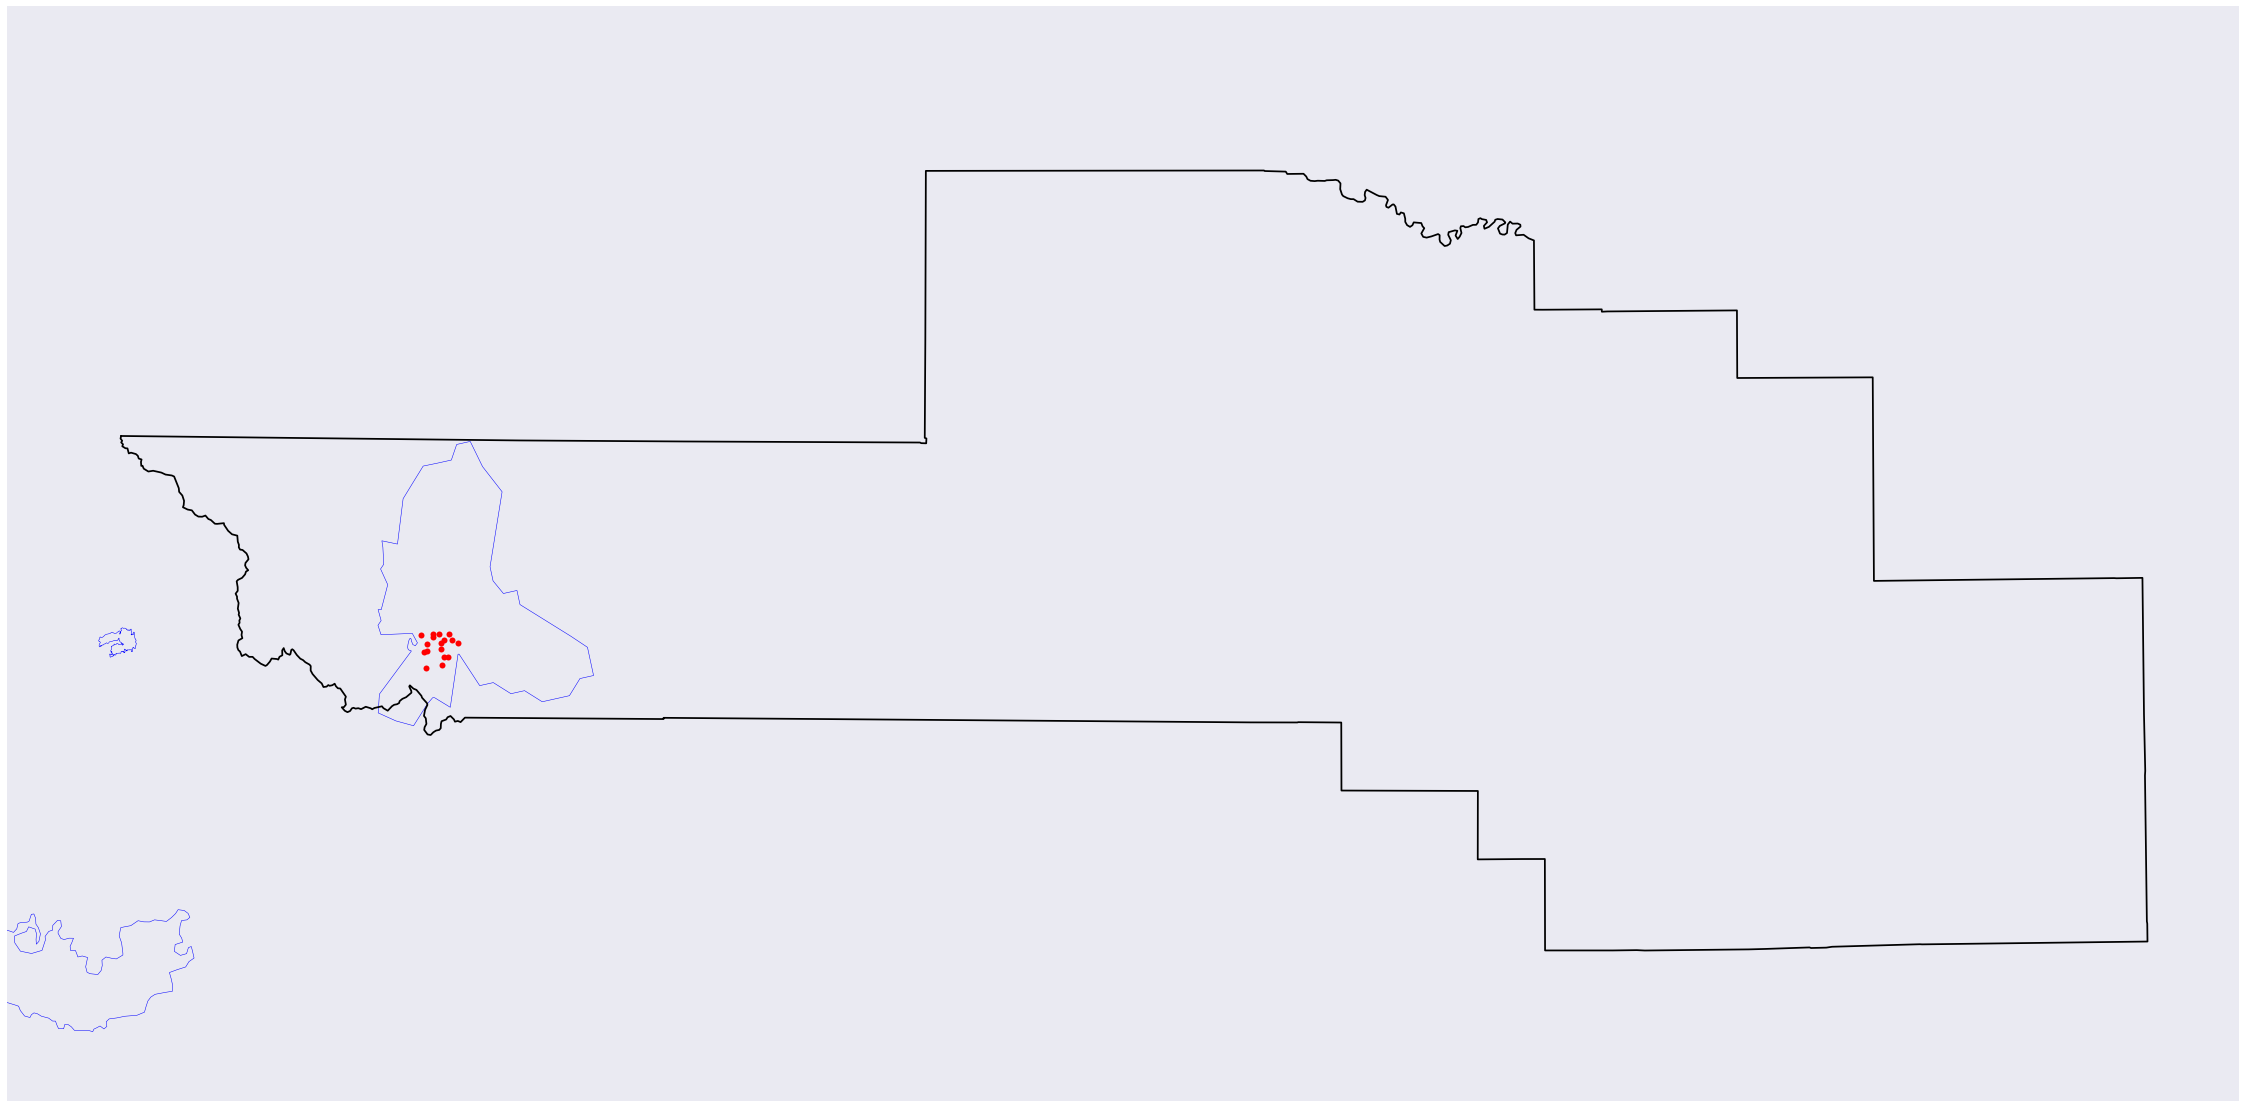

In [10]:
plot_shapely('Montana', 'mt', '30', 'Pondera', fires_dt='2015-08-27', 
                    perims_dt='2015-08-29')

(17, 3)
Pondera Montana
17


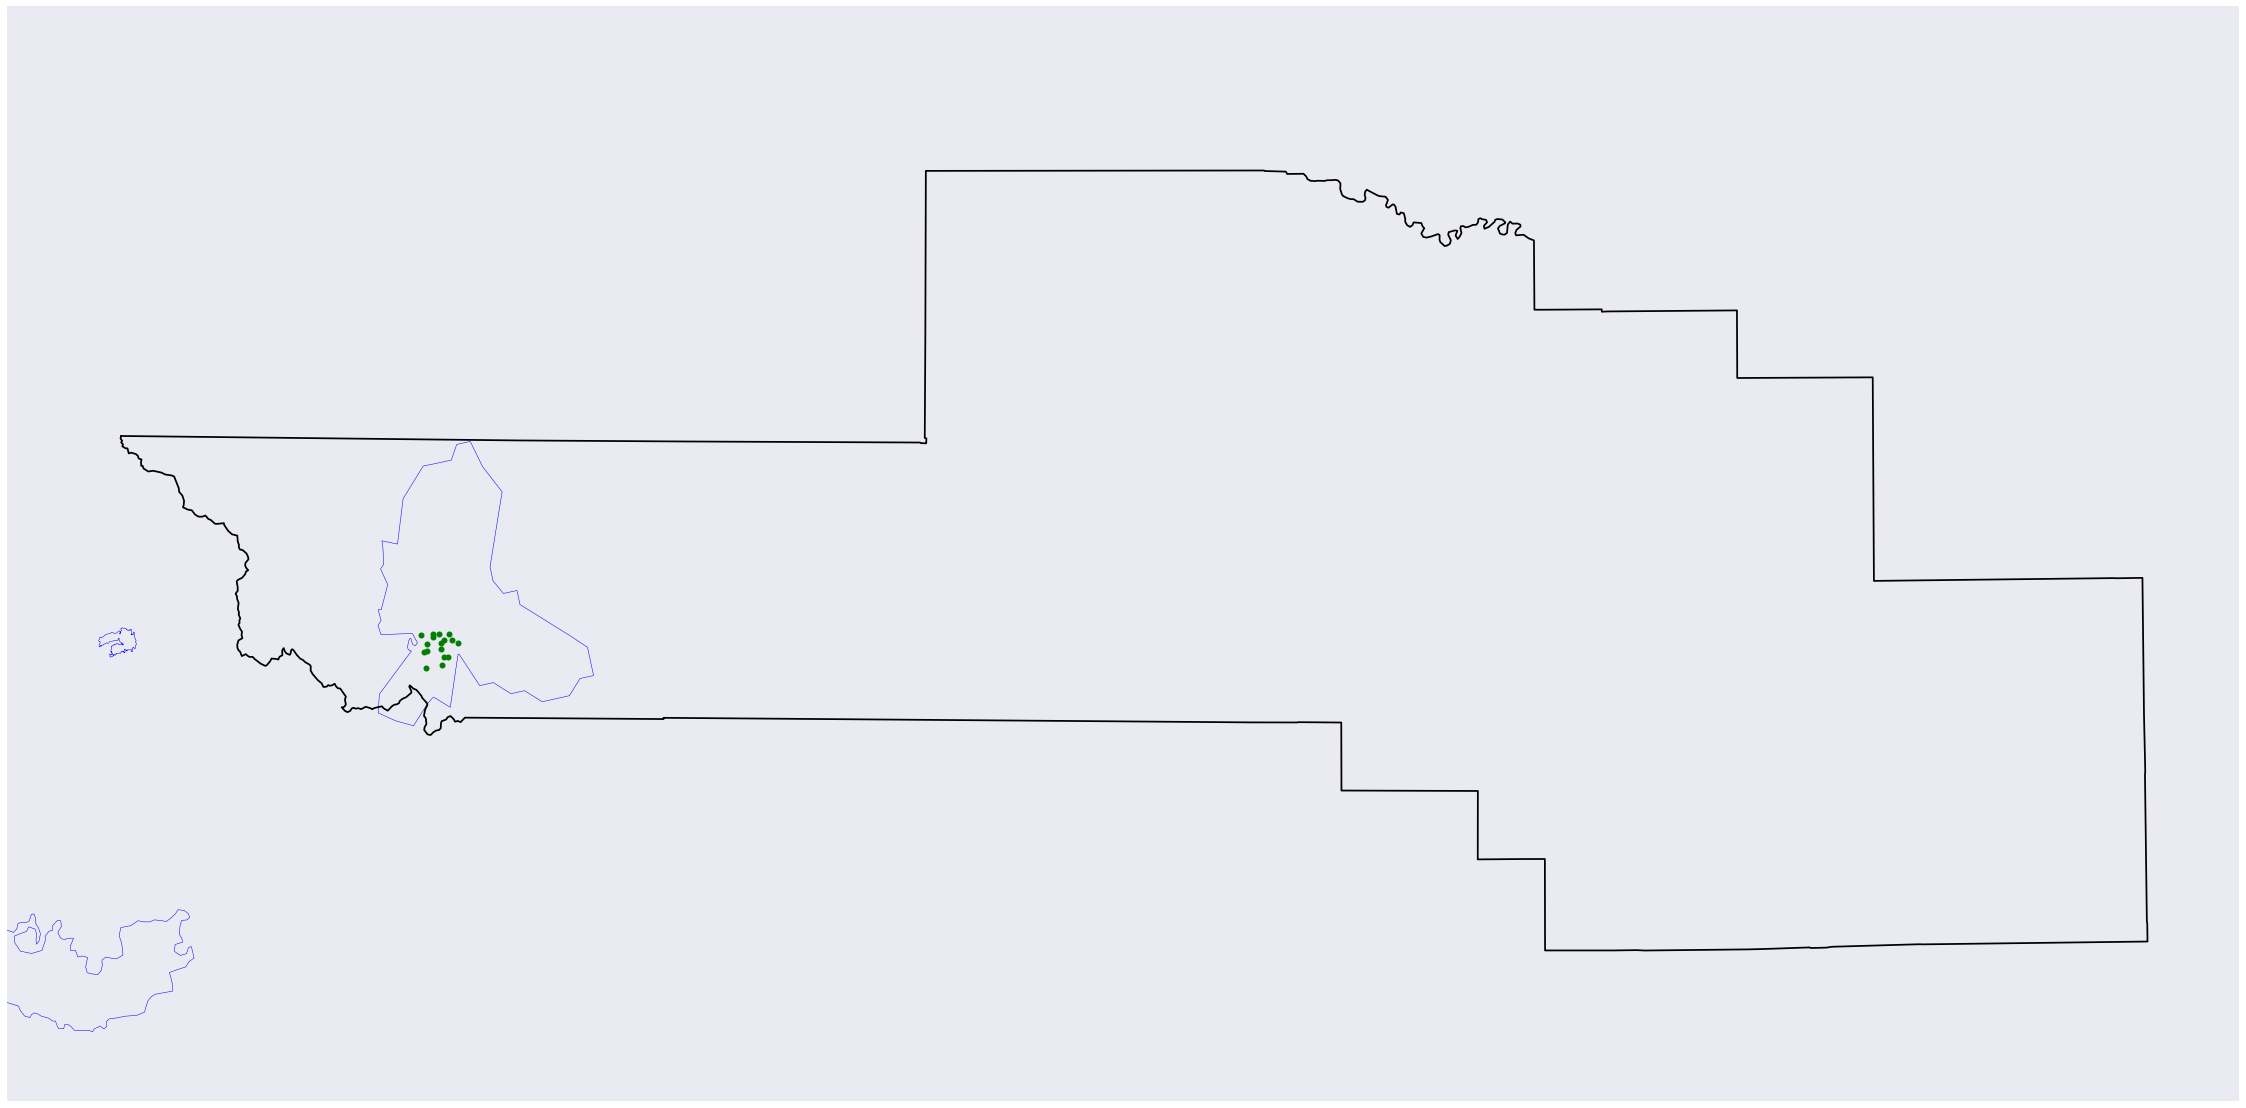

In [11]:
plot_county_dt('Montana', 'mt', '30', 'Pondera', fires_dt='2015-08-27', 
              perims_dt='2015-08-29')

/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sallamander/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

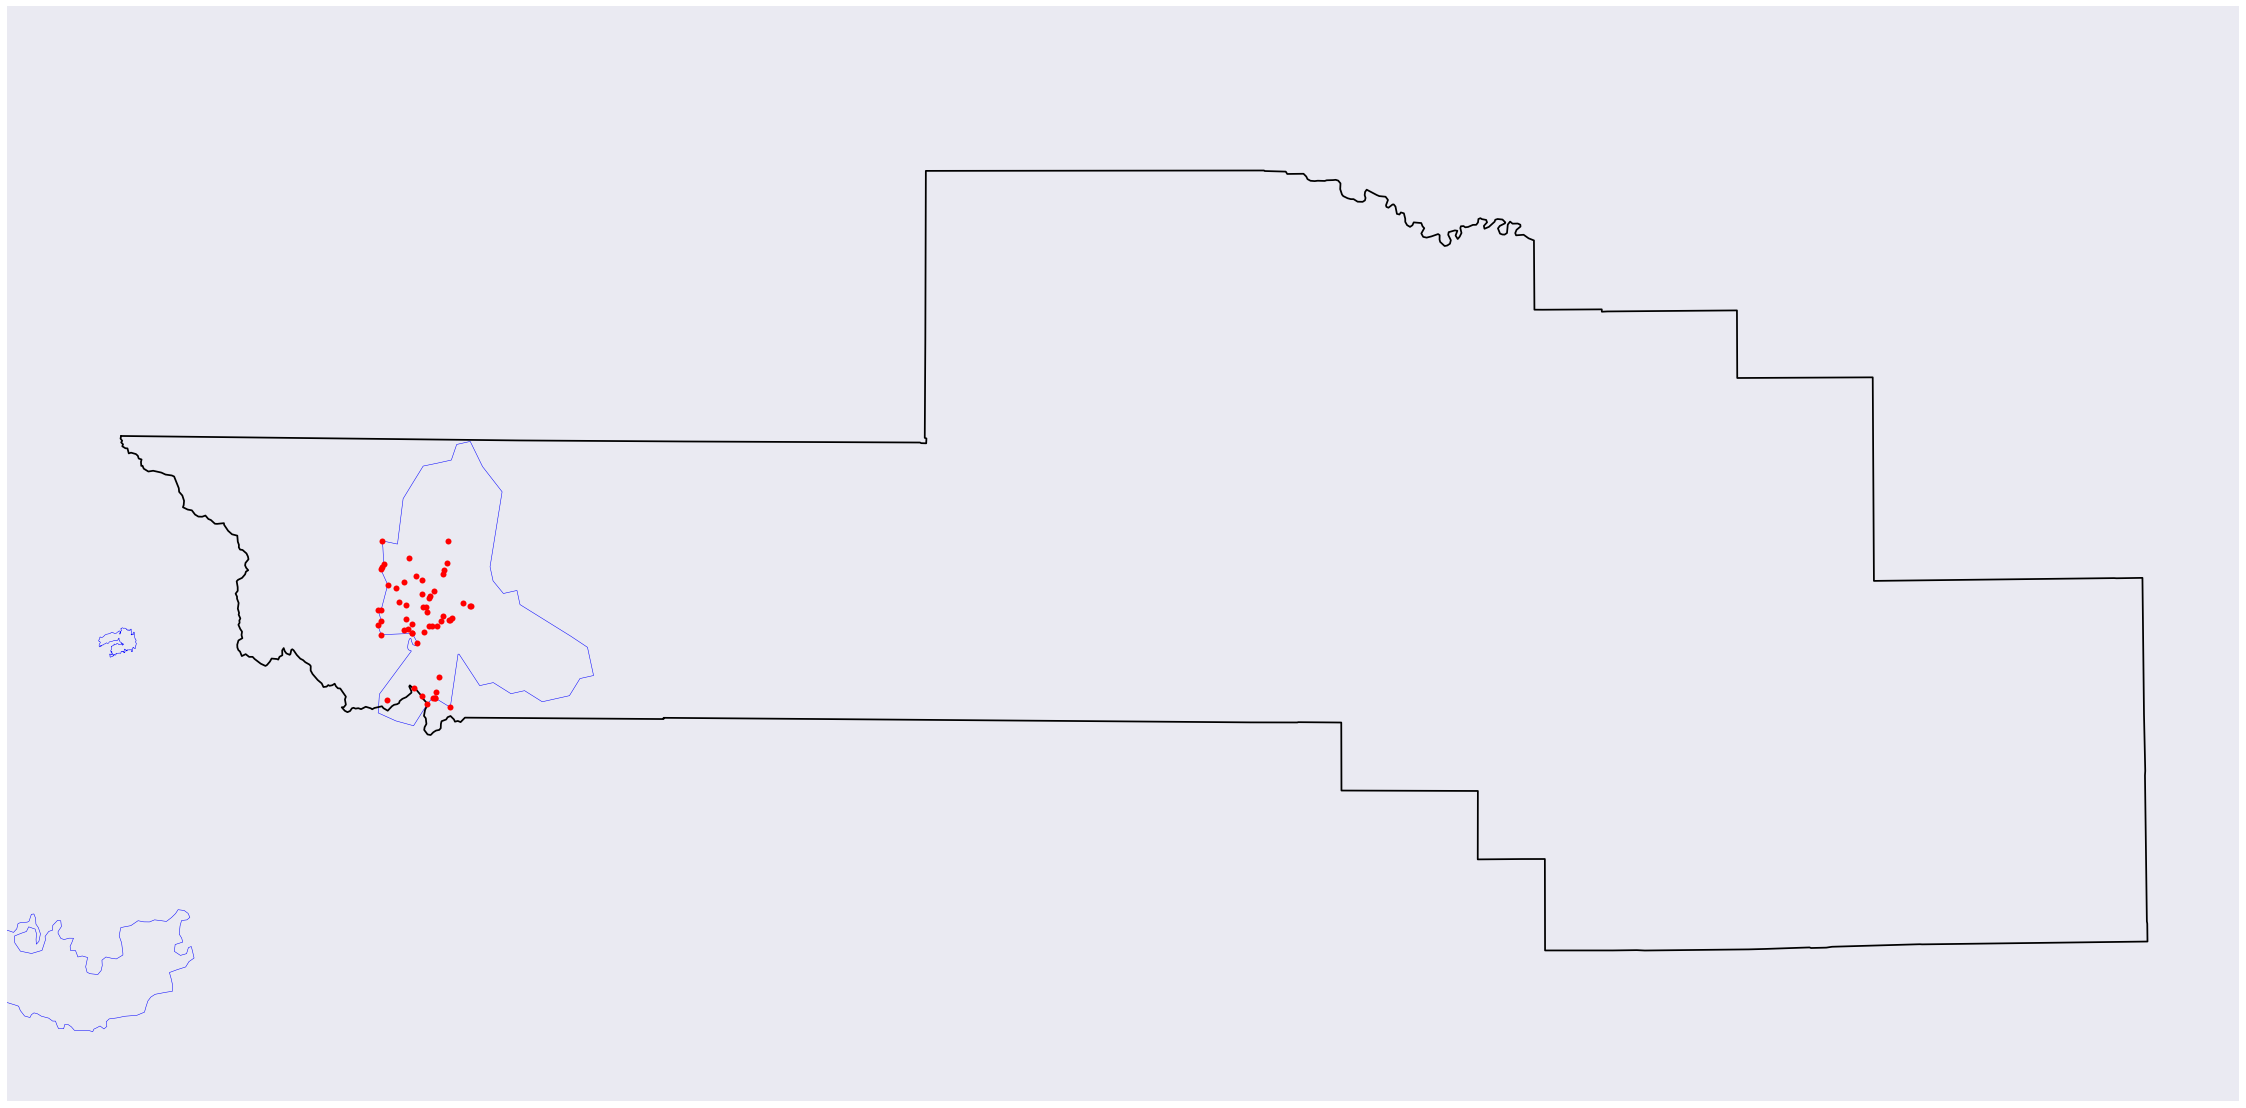

In [12]:
plot_shapely('Montana', 'mt', '30', 'Pondera', fires_dt='2015-08-28', 
                    perims_dt='2015-08-29')

(57, 3)
Pondera Montana
57


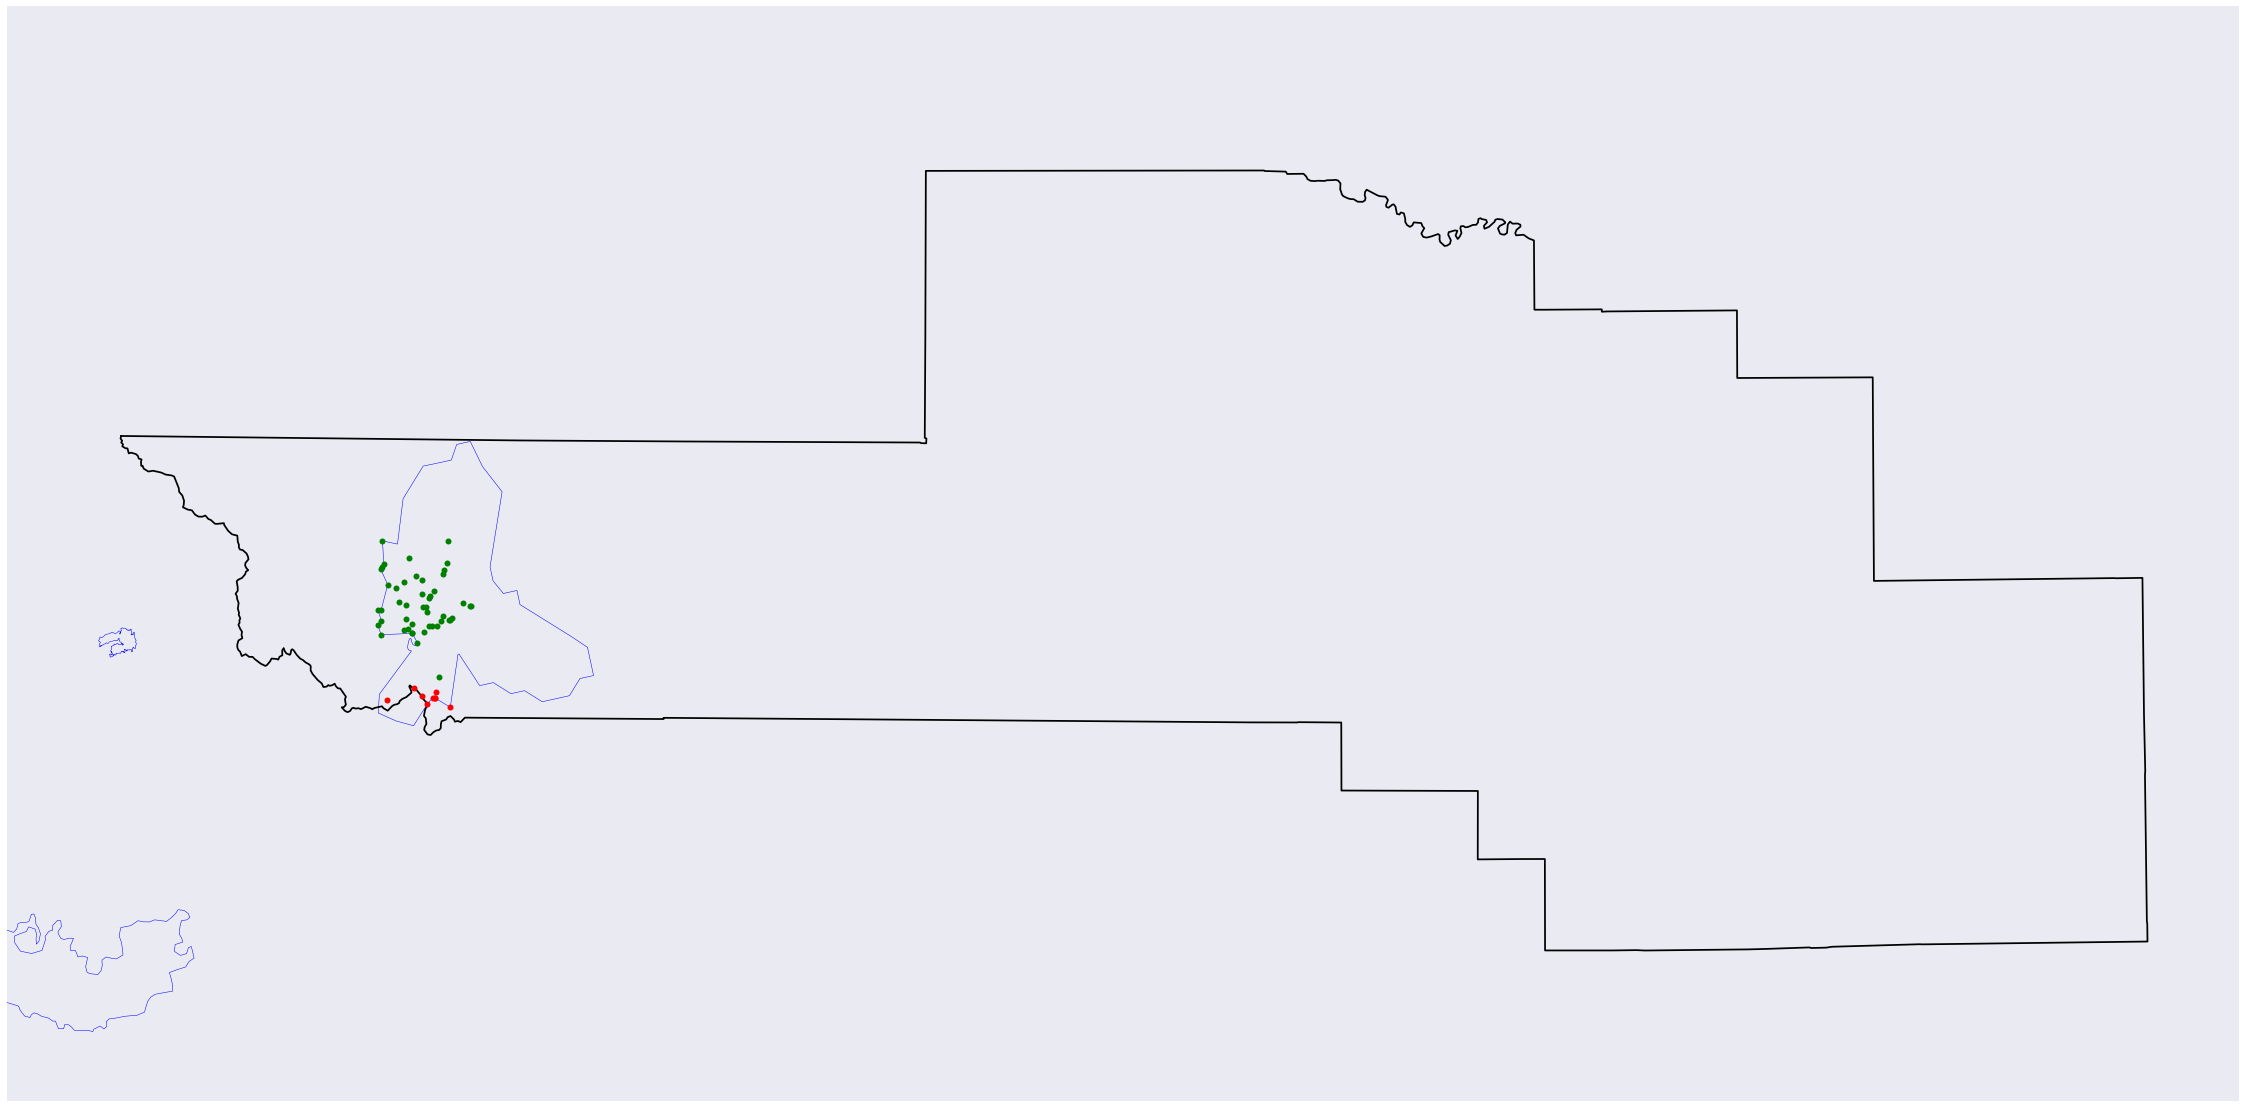

In [13]:
plot_county_dt('Montana', 'mt', '30', 'Pondera', fires_dt='2015-08-28', 
              perims_dt='2015-08-29')

It's clear from the above merging that the postgreSQL is not quite merging correctly, and the shapely/fiona stuff is doing what I want. The next step is to code up the ground truth labeling process so that it actually uses this shapely/fiona to label the ground truth for all observations. 